In [1]:
import os

from langchain_text_splitters import MarkdownHeaderTextSplitter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from src.config import settings

In [2]:
# df = pd.read_parquet(os.path.join(settings.data_dir, "arxiver/data/train.parquet"))
# ## Sample 10k
# df = df.sample(10000)
# print(df.shape, df.columns)

In [3]:
# df.to_parquet("sample.parquet", index = None)
df = pd.read_parquet("sample.parquet")
print(df.shape, df.columns)

(10000, 7) Index(['id', 'title', 'abstract', 'authors', 'published_date', 'link',
       'markdown'],
      dtype='object')


In [4]:
## Initialize Splitter
headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
]
splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)

# Test 1. custom implementation
* stack-based

In [5]:
# Test Sample
'''
Abstract is usually defined as
'###### Abstract'
'''
idx = 0
# idx = 15
sample = df.iloc[idx]['markdown']
# print(len(sample), sample[:200])
print(sample)

# Synthesis of Data-Driven Nonlinear State Observers using Lipschitz-Bounded Neural Networks

###### Abstract

This paper focuses on the _model-free_ synthesis of state observers for nonlinear autonomous systems without knowing the governing equations. Specifically, the Kazantzis-Kravaris/Luenberger (KKL) observer structure is leveraged, where the outputs are fed into a linear time-invariant (LTI) system to obtain the observer states, which can be viewed as the states nonlinearly transformed by an immersion mapping, and a neural network is used to approximate the inverse of the nonlinear immersion and estimate the states. In view of the possible existence of noises in output measurements, this work proposes to impose an upper bound on the Lipschitz constant of the neural network for robust and safe observation. A relation that bounds the generalization loss of state observation according to the Lipschitz constant, as well as the \(H_{2}\)-norm of the LTI part in the KKL observer, is es

In [6]:
sample_splits = splitter.split_text(sample)
print(len(sample_splits))
sample_splits

6


[Document(metadata={'Header 1': 'Synthesis of Data-Driven Nonlinear State Observers using Lipschitz-Bounded Neural Networks'}, page_content='###### Abstract  \nThis paper focuses on the _model-free_ synthesis of state observers for nonlinear autonomous systems without knowing the governing equations. Specifically, the Kazantzis-Kravaris/Luenberger (KKL) observer structure is leveraged, where the outputs are fed into a linear time-invariant (LTI) system to obtain the observer states, which can be viewed as the states nonlinearly transformed by an immersion mapping, and a neural network is used to approximate the inverse of the nonlinear immersion and estimate the states. In view of the possible existence of noises in output measurements, this work proposes to impose an upper bound on the Lipschitz constant of the neural network for robust and safe observation. A relation that bounds the generalization loss of state observation according to the Lipschitz constant, as well as the \\(H_{2}

In [7]:
import re
def parse_markdown_hierarchy(text):
    # Split the text into lines
    lines = text.strip().split('\n')
    # Define a pattern to match headers (from # to ######)
    header_pattern = re.compile(r'^(#{1,6})\s*(.*)$')

    # Initialize the root of the hierarchy
    root = {'children': []}
    # Stack to keep track of the current hierarchy levels
    stack = [{'level': 0, 'node': root}]
    # Accumulate text for the current node
    current_text = []

    for line in lines:
        header_match = header_pattern.match(line)
        if header_match:
            # If we have accumulated text, add it to the current node
            if current_text:
                # Join accumulated text and add to the last node's 'text'
                stack[-1]['node'].setdefault('text', '')
                if stack[-1]['node']['text']:
                    stack[-1]['node']['text'] += '\n'
                stack[-1]['node']['text'] += '\n'.join(current_text).strip()
                current_text = []
            # Extract header level and text
            header_marks, header_text = header_match.groups()
            level = len(header_marks)
            # Pop the stack to find the correct parent level
            while stack and stack[-1]['level'] >= level:
                stack.pop()
            # Create a new node for the header
            node = {
                'header': f'h{level}',
                'value': header_text.strip(),
                'children': []
            }
            # Add the new node to its parent's 'children'
            stack[-1]['node']['children'].append(node) ## parent
            # Push the new node onto the stack
            stack.append({'level': level, 'node': node}) ## for accumulating potential children
        else:
            # Accumulate non-header lines
            current_text.append(line)
    # After processing all lines, add any remaining text
    if current_text:
        stack[-1]['node'].setdefault('text', '')
        if stack[-1]['node']['text']:
            stack[-1]['node']['text'] += '\n'
        stack[-1]['node']['text'] += '\n'.join(current_text).strip()
    # Return the hierarchy starting from the root's children
    return root['children']
hierarchical_structure = parse_markdown_hierarchy(sample)

In [8]:
import pprint
pprint.pprint(hierarchical_structure, width=100)

[{'children': [{'children': [],
                'header': 'h6',
                'text': 'This paper focuses on the _model-free_ synthesis of state observers for '
                        'nonlinear autonomous systems without knowing the governing equations. '
                        'Specifically, the Kazantzis-Kravaris/Luenberger (KKL) observer structure '
                        'is leveraged, where the outputs are fed into a linear time-invariant '
                        '(LTI) system to obtain the observer states, which can be viewed as the '
                        'states nonlinearly transformed by an immersion mapping, and a neural '
                        'network is used to approximate the inverse of the nonlinear immersion and '
                        'estimate the states. In view of the possible existence of noises in '
                        'output measurements, this work proposes to impose an upper bound on the '
                        'Lipschitz constant of the neur

In [9]:
def get_node_texts(node):
    texts = [node["text"]]
    for child in node["children"]:
        texts.extend(get_node_texts(child))
    return texts

In [10]:
## Top Section
top_section = hierarchical_structure[0]
header_type = top_section["header"]
section_name = top_section["value"]
print(header_type, section_name)


for section in top_section["children"]:
    header_type = section["header"]
    section_name = section["value"]
    print(header_type, section_name, len(section["children"]))

h1 Synthesis of Data-Driven Nonlinear State Observers using Lipschitz-Bounded Neural Networks
h6 Abstract 0
h2 I Introduction 0
h2 II Preliminaries 2
h2 III Analysis on the Generalized Loss 0
h2 IV Case Study 0
h2 V Conclusions and Discussions 0


In [11]:
section_texts = []
for section in top_section["children"]:
    header_type = section["header"]
    section_name = section["value"]
    if section_name.lower()=="abstract":
        continue
    
    section_text = get_node_texts(section)
    section_texts.append(section_text)

In [12]:
[len("\n".join(x)) for x in section_texts]

[4958, 9149, 7740, 5915, 1977]

In [13]:
top_section["children"][2]

{'header': 'h2',
 'value': 'II Preliminaries',
 'children': [{'header': 'h3',
   'value': '_KKL Observer_',
   'children': [],
   'text': 'For nonlinear systems, KKL observer generalizes the notion of Luenberger observers that were restricted to linear systems [14], providing a generic method for state observation with mild assumptions to guarantee existence. Specifically, the KKL observer for (1) is expressed as\n\n\\[\\dot{z}(t)=Az(t)+By(t),\\quad\\hat{x}(t)=T^{\\dagger}(z(t)). \\tag{2}\\]\n\nHere the observer states \\(z\\in\\mathbb{R}^{n_{z}}\\) has an LTI dynamics. The matrices \\(A\\) and \\(B\\) are chosen under the requirements of (i) controllability of \\((A,B)\\) should be controllable, (ii) Hurwitz property of \\(A\\), and (iii) sufficiently high dimension of \\(z\\) (\\(n_{z}\\)), which should be at least \\(n+1\\) if \\((A,B)\\) is complex [17] and at least \\(2n+1\\) if \\((A,B)\\) is real [29]. The mapping from the observer states \\(z\\) to the state estimates \\(\\hat{

In [14]:
section_texts = get_node_texts(top_section["children"][2])
print(len(section_texts))
section_texts

3


['We consider a nonlinear autonomous system:\n\n\\[\\dot{x}(t)=f(x(t)),\\quad y(t)=h(x(t)) \\tag{1}\\]\n\nwhere \\(x(t)\\in\\mathcal{X}\\subseteq\\mathbb{R}^{n}\\) is the vector of states and \\(y(t)\\in\\mathbb{R}^{m}\\) represents the outputs. For simplicity, we will consider \\(m=1\\). It is assumed that \\(f\\) and \\(h\\) are smooth on \\(\\mathcal{X}\\) to guarantee existence and uniqueness of solution but unknown for model-based synthesis.',
 'For nonlinear systems, KKL observer generalizes the notion of Luenberger observers that were restricted to linear systems [14], providing a generic method for state observation with mild assumptions to guarantee existence. Specifically, the KKL observer for (1) is expressed as\n\n\\[\\dot{z}(t)=Az(t)+By(t),\\quad\\hat{x}(t)=T^{\\dagger}(z(t)). \\tag{2}\\]\n\nHere the observer states \\(z\\in\\mathbb{R}^{n_{z}}\\) has an LTI dynamics. The matrices \\(A\\) and \\(B\\) are chosen under the requirements of (i) controllability of \\((A,B)\\) sh

# Section count test

In [24]:
num_sections = []
has_title_count = 0
no_title_count = 0

for idx in tqdm(range(df.shape[0])):
    text = df.iloc[idx]['markdown']
    hierarchical_structure = parse_markdown_hierarchy(text)
    
    # has H1 Title 
    if len(hierarchical_structure)==1 and hierarchical_structure[0]['header']=='h1':
        has_title_count+=1
        num_section = 0
        top_section = hierarchical_structure[0]
        for section in top_section["children"]:
            header_type = section["header"]
            section_name = section["value"]
            if section_name.lower()=="abstract":
                continue
            num_section+=1
        num_sections.append(num_section)
    elif len(hierarchical_structure)>1:
        no_title_count+=1
        num_section = 0
        for section in hierarchical_structure:
            header_type = section["header"]
            section_name = section["value"]
            if section_name.lower()=="abstract":
                continue
            num_section+=1
        num_sections.append(num_section)
    else:
        print("ERR {} - {}".format(idx, hierarchical_structure, len(hierarchical_structure)))
        
print("has title {}, no title {}".format(has_title_count, no_title_count))

 72%|███████▏  | 7220/10000 [00:00<00:00, 8795.50it/s]

ERR 5786 - [{'header': 'h2', 'value': 'Abstract', 'children': [{'header': 'h6', 'value': 'Contents', 'children': [], 'text': '* 1 Introduction\n* 2 Model and Method\n\t* 2.1 Model\n\t* 2.2 Method\n\t* 2.3 Dynamical Correlation Functions\n\t* 2.4 Current-current correlation function\n* 3 Correlation functions\n\t* 3.1 \\(T=0\\)'}], 'text': "**Using variational matrix product states, we analyze the finite temperature behavior of a half-filled periodic Anderson model in one dimension, a prototypical model of a Kondo insulator. We present an extensive analysis of single-particle Green's functions, two-particle Green's functions, and transport functions creating a broad picture of the low-temperature properties. We confirm the existence of energetically low-lying spin excitations in this model and study their energy-momentum dispersion and temperature dependence. We demonstrate that charge-charge correlations at the Fermi energy exhibit a different temperature dependence than spin-spin corr

100%|██████████| 10000/10000 [00:01<00:00, 8996.91it/s]

has title 8468, no title 1531


In [25]:
num_sections_np = np.array(num_sections)
print("MAX {} AVG {} MIN {}".format(num_sections_np.max(), num_sections_np.mean(), num_sections_np.min()))

MAX 43 AVG 5.901490149014902 MIN 0


In [26]:
num_sections_np[num_sections_np==2].shape

(241,)

In [27]:
(num_sections_np==2).nonzero()[0][:30]

array([  27,   54,   88,  160,  190,  218,  250,  259,  271,  304,  344,
        384,  521,  523,  524,  563,  571,  624,  742,  760,  820,  868,
       1006, 1095, 1147, 1208, 1232, 1237, 1263, 1297])

In [28]:
# idx = 7843 ## 43 sections
# https://arxiv.org/pdf/2308.03803

idx = 27 ## 2 sections
# https://arxiv.org/pdf/2301.09285
text = df.iloc[idx]['markdown']
# print(text)
hierarchical_structure = parse_markdown_hierarchy(text)
print(len(hierarchical_structure[0]['children']))
hierarchical_structure

for section in hierarchical_structure[0]["children"]:
    header_type = section["header"]
    section_name = section["value"]
    print(header_type, section_name, len(section["children"]))

3
h6 Abstract 0
h2 I Introduction 0
h2 Appendix A Complex representation of a real wave 0


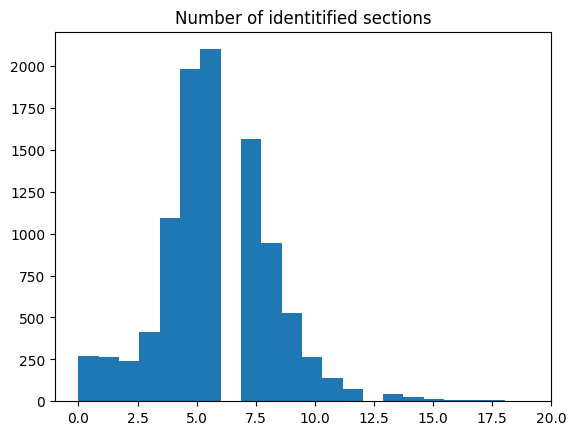

In [29]:
plt.clf()
plt.hist(num_sections, bins = 50)
plt.xlim(-1, 20)
plt.title("Number of identitified sections")
plt.show()

# Test 2. md2py based

In [30]:
# from md2py import md2py, TreeOfContents
from src.custom_md2py import md2py, TreeOfContents

In [37]:
## test md2py
idx = 0 # has title
# [Synthesis of Data-Driven Nonlinear State Observers using Lipschitz-Bounded Neural Networks]
idx = 14 # has sections
# [Enhanced Chart Understanding in Vision and Language Task via Cross-modal Pre-training on Plot Table Pairs,
#  Abstract,
#  Building cross-model intelligence that can understand charts and communicate the salient information hidden behind them is an appealing challenge in the vision and language (V+L) community. The capability to uncover the underlined table data of chart figures is a critical key to automatic chart understanding. We introduce ChartT5, a V+L model that learns how to interpret table information from chart images via cross-modal pre-training on plot table pairs. Specifically, we propose two novel pre-training objectives: Masked Header Prediction (MHP) and Masked Value Prediction (MVP) to facilitate the model with different skills to interpret the table information. We have conducted extensive experiments on chart question answering and chart summarization to verify the effectiveness of the proposed pre-training strategies. In particular, on the ChartQA benchmark, our ChartT5 outperforms the state-of-the-art non-pretraining methods by over (8\%) performance gains.,
#  1 Introduction,
#  2 Related Work,
#  3 Method,
#  4 Experiment,
#  5 Conclusion,
#  6 Limitations,
#  7 Ethics Statement,
#  Acknowledgement]

sample = df.iloc[idx]["markdown"]
toc = md2py(sample)
toc.branches
for child in toc.branches:
    print(child.name, child.string)
    print("Depth:",child.depth)
    print("Heading:",TreeOfContents.getHeadingLevel(child))
    for subchild_i, subchild in enumerate(child.branches):
        print("SUBCHILD {} - tag {}".format(subchild_i, subchild.name))
        # print(subchild.string)
    expanded_children = child.expandDescendants(child)
    print("Branches:", len(child.branches))
    print("Expanded Branches:", len(expanded_children))
    
    print('-'*30)
type(toc.branches[0])

p Enhanced Chart Understanding in Vision and Language Task via Cross-modal Pre-training on Plot Table Pairs
Depth: 3
Heading: None
Branches: 0
Expanded Branches: 0
------------------------------
h6 Abstract
Depth: 3
Heading: 6
Branches: 0
Expanded Branches: 0
------------------------------
p Building cross-model intelligence that can understand charts and communicate the salient information hidden behind them is an appealing challenge in the vision and language (V+L) community. The capability to uncover the underlined table data of chart figures is a critical key to automatic chart understanding. We introduce ChartT5, a V+L model that learns how to interpret table information from chart images via cross-modal pre-training on plot table pairs. Specifically, we propose two novel pre-training objectives: Masked Header Prediction (MHP) and Masked Value Prediction (MVP) to facilitate the model with different skills to interpret the table information. We have conducted extensive experiments 

src.custom_md2py.TreeOfContents

In [33]:
# print(sample)